<a href="https://colab.research.google.com/github/bishram-acharya/Cross-Platform-Fingerprint-Matching-using-CNN/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook we will build an evaluator to calculate accuract,precision, recall, f1 score and confusion matrix. Further, we will also plot different graphs for each model

## Making necessary imports

In [ ]:
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras import backend as K
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


## Building evaluator function
- We will preprocess these test images the same way as our train images.
- Then we will make prediction on them and calculate metrics

In [ ]:


model_path = '/content/drive/My Drive/minor_project_1/FinePreProcessNorm_dropAP.h5'
test_csv_path = '/content/drive/My Drive/minor_data/goodquality/quality_test_final.csv'
contactbased_base_path = '/content/drive/My Drive/minor_data/goodquality/test_contactbased/'
contactless_base_path = '/content/drive/My Drive/minor_data/goodquality/quality_contactless/'

# Load the model
try:
    model = tf.keras.models.load_model(model_path)
except FileNotFoundError:
    print("Model file not found at:", model_path)
    exit()

# Load test dataset from CSV
try:
    test_df = pd.read_csv(test_csv_path)




except FileNotFoundError:
    print("Test CSV file not found at:", test_csv_path)
    exit()

# Define test dataset paths based on DataFrame columns
test_contactbased_paths = contactbased_base_path + test_df['contactbased_path']
test_contactless_paths = contactless_base_path + test_df['contactless_path']
test_labels = test_df['label']  # assuming 'label' is the column name for labels

# Filter out paths that do not exist
existing_contactbased_paths = test_contactbased_paths[test_contactbased_paths.apply(os.path.exists)]
existing_contactless_paths = test_contactless_paths[test_contactless_paths.apply(os.path.exists)]
existing_labels = test_labels[test_contactless_paths.apply(os.path.exists)]

# Load and preprocess test datasets
def load_and_preprocess_test_image_contactbased(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_bmp(image, channels=3)
    # Preprocess image if necessary (resize, normalize, etc.)
    image = tf.image.resize(image, size=(224, 224))
    return image

def load_and_preprocess_test_image_contactless(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    # Preprocess image if necessary (resize, normalize, etc.)
    image = tf.image.resize(image, size=(224, 224))
    return image

# Load and preprocess test datasets
test_contactbased_dataset = tf.data.Dataset.from_tensor_slices(existing_contactbased_paths).map(load_and_preprocess_test_image_contactbased, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_contactless_dataset = tf.data.Dataset.from_tensor_slices(existing_contactless_paths).map(load_and_preprocess_test_image_contactless, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(existing_labels)

# Combine contactbased and contactless datasets into a single dataset
test_combined_dataset = tf.data.Dataset.zip((test_contactbased_dataset, test_contactless_dataset))

# Combine features and labels
test_dataset = tf.data.Dataset.zip((test_combined_dataset, test_labels_dataset))

# Preprocess test dataset
batch_size = 32
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Assuming you already defined and compiled your Siamese VGG16 model as 'model'
# Evaluate the model on the test dataset
# test_results = model.evaluate(test_dataset)

# Predict labels using the trained model with a threshold of 0.5
test_predictions = []
without_threshold = []
for features_batch, _ in test_dataset:
    predictions_batch = model.predict(features_batch)
    without_threshold.extend(predictions_batch)
    binary_predictions_batch = (predictions_batch > 0.5).astype(int)  # Apply threshold of 0.5
    test_predictions.extend(binary_predictions_batch)

# Extract labels from the test dataset
test_labels = []
for _, labels_batch in test_dataset:
    test_labels.extend(labels_batch)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
accuracy = accuracy_score(test_labels, test_predictions)


# Display test results

print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


1/1 [==============================] - 3s 3s/step
Test Accuracy: 0.7879356568364612
Precision: 0.7937806873977087
Recall: 0.7789079229122056
F1 Score: 0.7862739800054039


Lets see what we have now

In [ ]:
test_labels_onehot = to_categorical(test_labels)
numpy_tensors = [tensor.numpy() for tensor in test_labels]
numpy_tensors[250:260]
scores = without_threshold[30:40]
lab = numpy_tensors[30:40]

scores


[array([0.9998554], dtype=float32),
 array([0.715337], dtype=float32),
 array([0.99991333], dtype=float32),
 array([1.8720712e-05], dtype=float32),
 array([0.99956375], dtype=float32),
 array([0.71758264], dtype=float32),
 array([0.99773836], dtype=float32),
 array([2.1908649e-05], dtype=float32),
 array([0.99999464], dtype=float32),
 array([0.2457617], dtype=float32)]

In [ ]:
lab

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [ ]:
# See scores for each label
for pair in zip(scores, lab):
  print(pair)


(array([0.9998554], dtype=float32), 1)
(array([0.715337], dtype=float32), 0)
(array([0.99991333], dtype=float32), 1)
(array([1.8720712e-05], dtype=float32), 0)
(array([0.99956375], dtype=float32), 1)
(array([0.71758264], dtype=float32), 0)
(array([0.99773836], dtype=float32), 1)
(array([2.1908649e-05], dtype=float32), 0)
(array([0.99999464], dtype=float32), 1)
(array([0.2457617], dtype=float32), 0)


## VGG-16 metrics

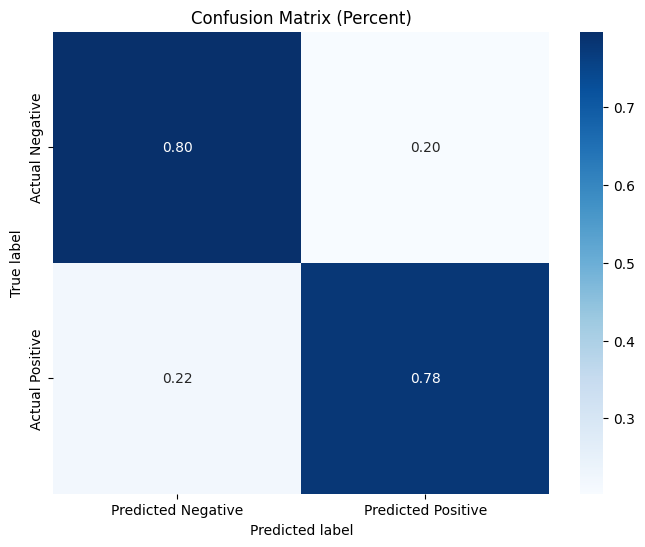

In [ ]:
# Build confusionmatrix function
def confusion_matrix_vgg():
  import numpy as np
  from sklearn.metrics import confusion_matrix
  import matplotlib.pyplot as plt
  import seaborn as sns

  # Calculate confusion matrix
  conf_matrix = confusion_matrix(test_labels, test_predictions)

  # Convert confusion matrix counts to percentages
  conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix (Percent)')
  plt.show()
confusion_matrix_vgg()


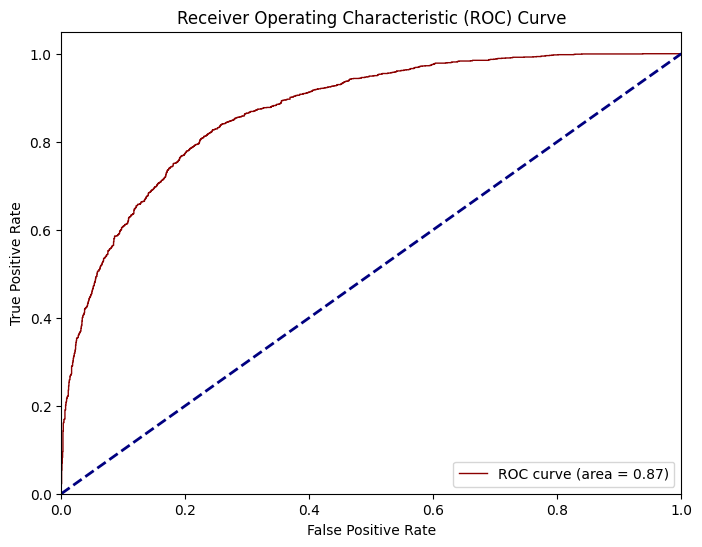

In [ ]:
# Generate Roc curve
def roc_curve():
  from sklearn.metrics import roc_curve, auc
  import matplotlib.pyplot as plt
  # Calculate ROC curve
  fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
  fpr1, tpr1, thresholds1 = roc_curve(test_labels, without_threshold)
  roc_auc = auc(fpr, tpr)
  roc_auc1 = auc(fpr1, tpr1)

  # Plott ROC curve
  plt.figure(figsize=(8, 6))
  # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot(fpr1, tpr1, color='darkred', lw=1, label='ROC curve (area = %0.2f)' % roc_auc1)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()
roc_curve()

In [ ]:
# Find our EER
def calculate_eer(fpr, tpr, thresholds):
    # Calculate FAR (False Acceptance Rate) and FRR (False Rejection Rate)
    far = 1 - tpr
    frr = fpr

    # Find the index where FAR is closest to FRR
    eer_index = np.argmin(np.abs(far - frr))

    # Equal Error Rate (EER) coordinates
    eer_far = far[eer_index]
    eer_frr = frr[eer_index]
    eer_threshold = thresholds[eer_index]

    eer = (eer_far + eer_frr) / 2

    return eer, eer_far, eer_frr, eer_threshold

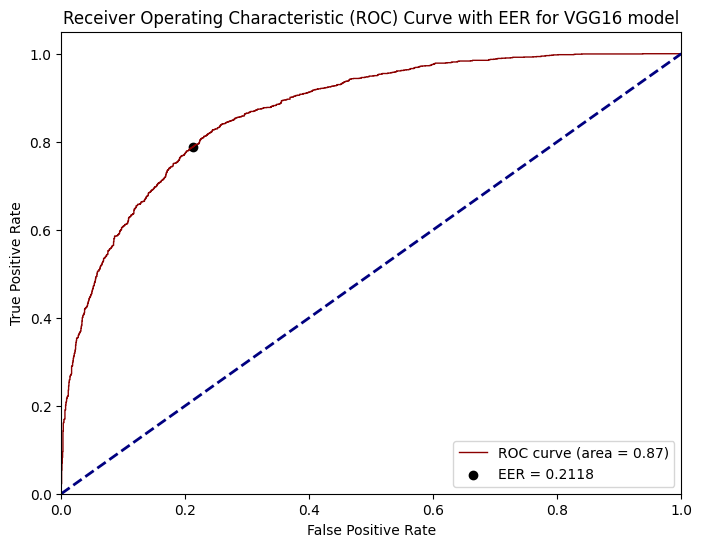

In [ ]:
# Plot roc with eer
def roc_curve_with_eer():
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    # Assuming you have the ROC curve represented as arrays of false positive rates (fpr)
    # and true positive rates (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(test_labels, without_threshold)
    roc_auc = auc(fpr, tpr)

    # Calculate EER
    eer, eer_far, eer_frr, eer_threshold = calculate_eer(fpr, tpr, thresholds)

    # Plot ROC curve with EER
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkred', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.scatter(eer_far, 1 - eer_frr, marker='o', color='black', label='EER = %0.4f' % eer)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve with EER for VGG16 model')
    plt.legend(loc="lower right")
    plt.show()

roc_curve_with_eer()

## Dense Net metrics

Preprocessing it like we did for VGG16

In [ ]:


model_path = '/content/drive/My Drive/minor_project_1/densenet/DENSE_AP_FT_WITHDROPOUT_15epo.h5'
test_csv_path = '/content/drive/My Drive/minor_data/goodquality/quality_test_final.csv'
contactbased_base_path = '/content/drive/My Drive/minor_data/goodquality/test_contactbased/'
contactless_base_path = '/content/drive/My Drive/minor_data/goodquality/quality_contactless/'

# Load the model
try:
    model = tf.keras.models.load_model(model_path)
except FileNotFoundError:
    print("Model file not found at:", model_path)
    exit()

# Load test dataset from CSV
try:
    test_df = pd.read_csv(test_csv_path)




except FileNotFoundError:
    print("Test CSV file not found at:", test_csv_path)
    exit()

# Define test dataset paths based on DataFrame columns
test_contactbased_paths = contactbased_base_path + test_df['contactbased_path']
test_contactless_paths = contactless_base_path + test_df['contactless_path']
test_labels = test_df['label']  # assuming 'label' is the column name for labels

# Filter out paths that do not exist
existing_contactbased_paths = test_contactbased_paths[test_contactbased_paths.apply(os.path.exists)]
existing_contactless_paths = test_contactless_paths[test_contactless_paths.apply(os.path.exists)]
existing_labels = test_labels[test_contactless_paths.apply(os.path.exists)]

# Load and preprocess test datasets
def load_and_preprocess_test_image_contactbased(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_bmp(image, channels=3)
    # Preprocess image if necessary (resize, normalize, etc.)
    image = tf.image.resize(image, size=(224, 224))
    return image

def load_and_preprocess_test_image_contactless(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    # Preprocess image if necessary (resize, normalize, etc.)
    image = tf.image.resize(image, size=(224, 224))
    return image

# Load and preprocess test datasets
test_contactbased_dataset = tf.data.Dataset.from_tensor_slices(existing_contactbased_paths).map(load_and_preprocess_test_image_contactbased, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_contactless_dataset = tf.data.Dataset.from_tensor_slices(existing_contactless_paths).map(load_and_preprocess_test_image_contactless, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(existing_labels)

# Combine contactbased and contactless datasets into a single dataset
test_combined_dataset = tf.data.Dataset.zip((test_contactbased_dataset, test_contactless_dataset))

# Combine features and labels
test_dataset = tf.data.Dataset.zip((test_combined_dataset, test_labels_dataset))

# Preprocess test dataset
batch_size = 32
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Assuming you already defined and compiled your Siamese VGG16 model as 'model'
# Evaluate the model on the test dataset
# test_results = model.evaluate(test_dataset)

# Predict labels using the trained model with a threshold of 0.5
test_predictions = []
floating_predictions = []
for features_batch, _ in test_dataset:
    predictions_batch = model.predict(features_batch)
    floating_predictions.extend(predictions_batch)
    binary_predictions_batch = (predictions_batch > 0.5).astype(int)  # Apply threshold of 0.5
    test_predictions.extend(binary_predictions_batch)

# Extract labels from the test dataset
test_labels = []
for _, labels_batch in test_dataset:
    test_labels.extend(labels_batch)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
accuracy = accuracy_score(test_labels, test_predictions)

# # Display test results
# print("Test Loss:", test_results[0])
# print("Test Accuracy:", test_results[1])
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)

# Display test results

print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


1/1 [==============================] - 11s 11s/step
Test Accuracy: 0.7638069705093834
Precision: 0.8391752577319588
Recall: 0.6536402569593148
F1 Score: 0.7348781221787541


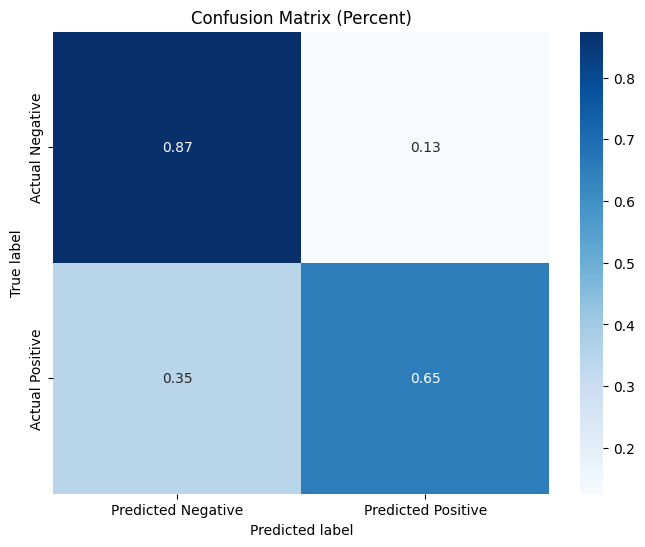

In [ ]:
# Confusion matrix plot
def confusion_matrix_densenet():
  import numpy as np
  from sklearn.metrics import confusion_matrix
  import matplotlib.pyplot as plt
  import seaborn as sns

  # Calculate confusion matrix
  conf_matrix = confusion_matrix(test_labels, test_predictions)

  # Convet confusion matrix counts to percentages
  conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix (Percent)')
  plt.show()
confusion_matrix_densenet()


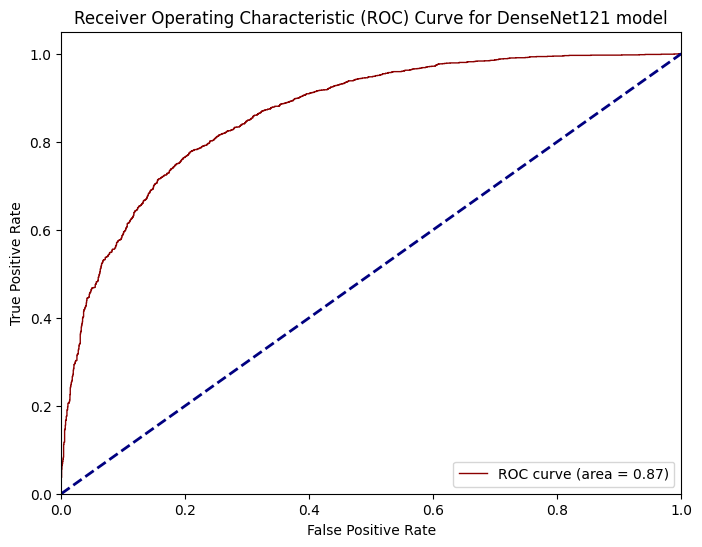

In [ ]:
# Plot roc curve
def roc_curve():
  from sklearn.metrics import roc_curve, auc
  import matplotlib.pyplot as plt
  # Calculate ROC curve
  #fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
  fpr1, tpr1, thresholds = roc_curve(test_labels, floating_predictions)
  roc_auc = auc(fpr1, tpr1)
  # Plott ROC curve
  plt.figure(figsize=(8, 6))
  #plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot(fpr1, tpr1, color='darkred', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve for DenseNet121 model')
  plt.legend(loc="lower right")
  plt.show()
roc_curve()


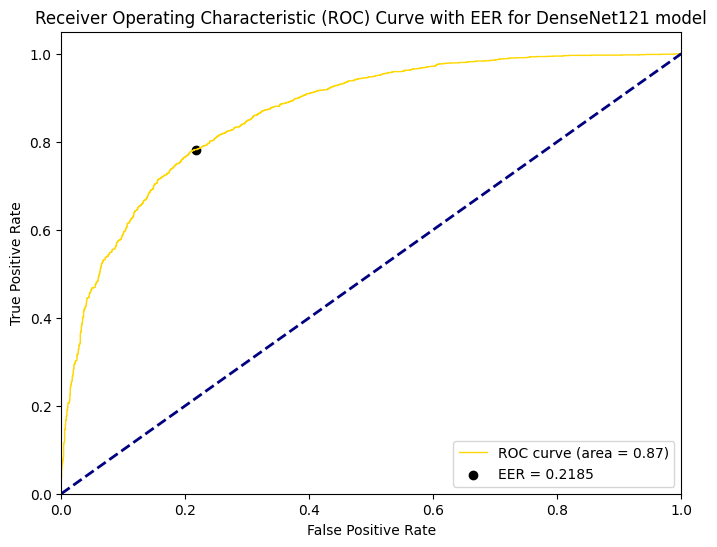

In [ ]:
# Plot alongside eer
def roc_curve_with_eer_densenet():
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    # Assuming you have the ROC curve represented as arrays of false positive rates (fpr)
    # and true positive rates (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(test_labels, floating_predictions)
    roc_auc = auc(fpr, tpr)

    # Calculate EER
    eer, eer_far, eer_frr, eer_threshold = calculate_eer(fpr, tpr, thresholds)

    # Plot ROC curve with EER
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='gold', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.scatter(eer_far, 1 - eer_frr, marker='o', color='black', label='EER = %0.4f' % eer)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve with EER for DenseNet121 model')
    plt.legend(loc="lower right")
    plt.show()

roc_curve_with_eer_densenet()

## Comparison between two models

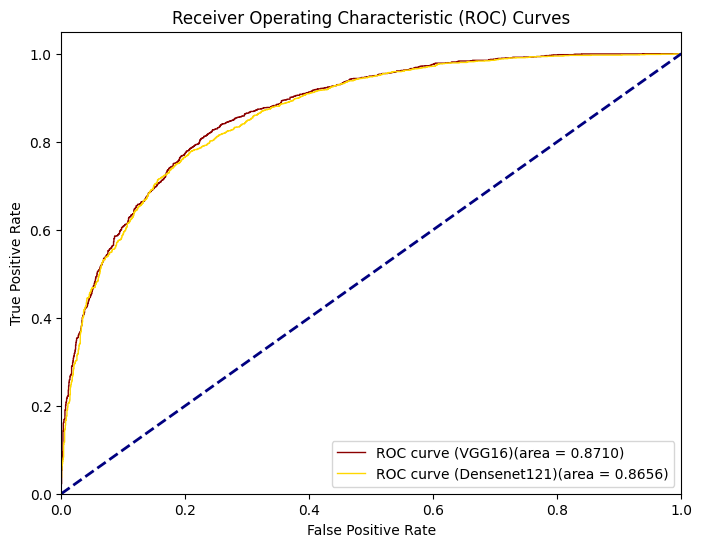

In [ ]:
def compareROC():
  from sklearn.metrics import roc_curve, auc
  import matplotlib.pyplot as plt

  fpr_vgg, tpr_vgg, thresholds_vgg = roc_curve(test_labels, without_threshold)
  fpr_densenet, tpr_densenet, thresholds_densenet = roc_curve(test_labels, floating_predictions)
  roc_auc_vgg = auc(fpr_vgg, tpr_vgg)
  roc_auc_densenet = auc(fpr_densenet, tpr_densenet)

  plt.figure(figsize=(8, 6))

  plt.plot(fpr_vgg, tpr_vgg, color='darkred', lw=1, label='ROC curve (VGG16)(area = %0.4f)' % roc_auc_vgg)
  plt.plot(fpr_densenet, tpr_densenet, color='gold', lw=1, label='ROC curve (Densenet121)(area = %0.4f)' % roc_auc_densenet)

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curves')
  plt.legend(loc="lower right")
  plt.show()
compareROC()

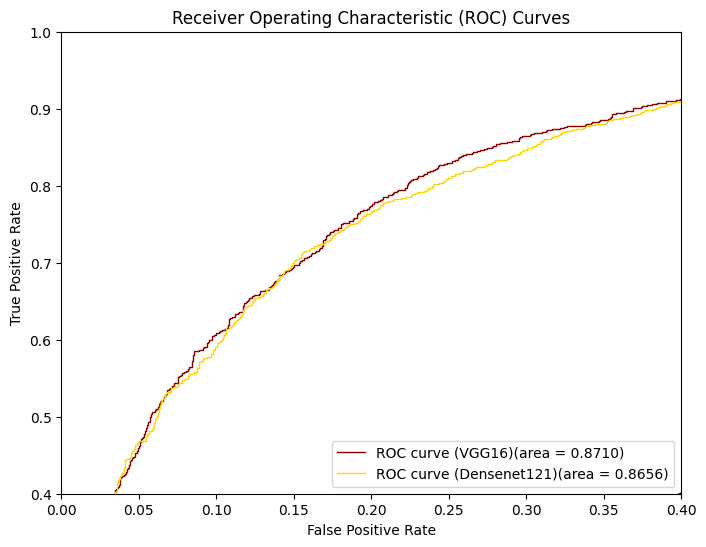

In [ ]:
def compareROCzoom():
  from sklearn.metrics import roc_curve, auc
  import matplotlib.pyplot as plt

  fpr_vgg, tpr_vgg, thresholds_vgg = roc_curve(test_labels, without_threshold)
  fpr_densenet, tpr_densenet, thresholds_densenet = roc_curve(test_labels, floating_predictions)
  roc_auc_vgg = auc(fpr_vgg, tpr_vgg)
  roc_auc_densenet = auc(fpr_densenet, tpr_densenet)

  plt.figure(figsize=(8, 6))

  plt.plot(fpr_vgg, tpr_vgg, color='darkred', lw=1, label='ROC curve (VGG16)(area = %0.4f)' % roc_auc_vgg)
  plt.plot(fpr_densenet, tpr_densenet, color='gold', lw=1, label='ROC curve (Densenet121)(area = %0.4f)' % roc_auc_densenet)

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0, 0.4])
  plt.ylim([0.4, 1])

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curves')
  plt.legend(loc="lower right")
  plt.show()
compareROCzoom()